<style>
@import url('https://fonts.googleapis.com/css2?family=Fira+Code:wght@300..700&display=swap');
</style>

<div style="text-align: center; font-family: 'Fira Code', serif;">
        
import library

</div>

In [ ]:
import math
from typing import Optional, Tuple, Union, List

import torch
import torch.nn as nn

from module import Module

from torchvision.datasets import MNIST

import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

<style>
@import url('https://fonts.googleapis.com/css2?family=Fira+Code:wght@300..700&display=swap');
</style>

<div style="text-align: center; font-family: 'Fira Code', serif;">
        
code parts of model

</div>

In [ ]:
class Swish(Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

In [ ]:
class ResidualBlock(Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1)) if in_channels != out_channels else nn.Identity()
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.shortcut(x)

In [ ]:
class AttentionBlock(Module):
    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()
        d_k = d_k if d_k is not None else n_channels
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        _ = t
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        return res

In [ ]:
class DownBlock(Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        self.attn = AttentionBlock(out_channels) if has_attn else nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

In [ ]:
class UpBlock(Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        self.attn = AttentionBlock(out_channels) if has_attn else nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

In [ ]:
class MiddleBlock(Module):
    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x

In [ ]:
class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _ = t
        return self.conv(x)

In [ ]:
class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _ = t
        return self.conv(x)

In [ ]:
class UNet(Module):
    def __init__(self, image_channels: int = 3, 
                 n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], 
                                 List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], 
                                List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()
        n_resolutions = len(ch_mults)
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmbedding(n_channels * 4)
        down = []
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))
        self.down = nn.ModuleList(down)
        self.middle = MiddleBlock(out_channels, n_channels * 4)
        up = []
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(Upsample(in_channels))
        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_emb(t)
        x = self.image_proj(x)
        h = [x]
        for m in self.down:
            x = m(x, t)
            h.append(x)
        x = self.middle(x, t)
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)
        return self.final(self.act(self.norm(x)))
    
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

model = UNet(image_channels=1).to(device=device)
trainable, non_trainable = count_parameters(model)
trainable, non_trainable = "{:,}".format(trainable), "{:,}".format(non_trainable)
print(f"Unet model: {model}")
print(f"Trainable parameters: {trainable}")
print(f"Non-trainable parameters: {non_trainable}")


Unet model: UNet(
  (image_proj): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=

In [ ]:
n_epochs =   75
batch_size =  1024 
lr=10e-4

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
optimizer = Adam(model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
mse_loss_fn = nn.MSELoss()
t = torch.randint(0, 1000, (batch_size,), device=device).float()

In [ ]:
tqdm_epoch = trange(n_epochs)
model.train()
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    y = x.clone()
    y_pred = model(x, t)
    loss = mse_loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch + 1, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(model.state_dict(), 'ckpt_res.pth')

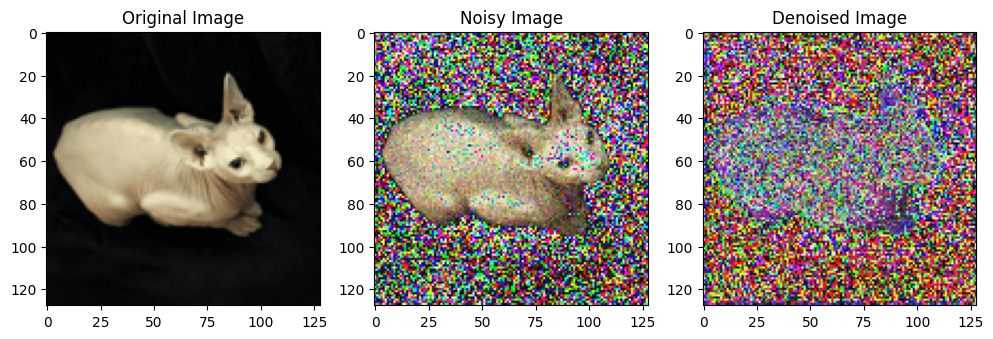